# Build nearest neighbor graph of spikes using spikeinterface spikesorting modules
- this notebooks 
    1. grabs all spikes in a recording (found with detect peaks) 
    2. computes sparse euclidean nearest neighbors over chunks of the recording
    3. merges that graph into a single nearest neighbors graph

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import spikeinterface.full as si
import probeinterface
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt
import numpy as np

In [3]:
base_folder = Path('/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/')
dataset_folder = base_folder/'Record Node 106'
probe_file = base_folder / 'A4x16-Poly3-5mm-20-200-160-H64LP.prb'

### Load dataset

In [4]:
rec = si.read_openephys(dataset_folder)
probe = probeinterface.io.read_prb(probe_file)
rec = rec.set_probe(probe.probes[0])

/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat
/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/Record Node 106/experiment1/recording1/continuous/Rhythm_FPGA-103.0/continuous.dat


In [5]:
probe.probes[0]._contact_positions[:,0]

array([  0. ,   0. ,   0. ,   0. ,   0. ,  17.3,  17.3,  17.3,  17.3,
        17.3,  17.3,  34.6,  34.6,  34.6,  34.6,  34.6, 200. , 200. ,
       200. , 200. , 200. , 217.3, 217.3, 217.3, 217.3, 217.3, 217.3,
       234.6, 234.6, 234.6, 234.6, 234.6, 400. , 400. , 400. , 400. ,
       400. , 417.3, 417.3, 417.3, 417.3, 417.3, 417.3, 434.6, 434.6,
       434.6, 434.6, 434.6, 600. , 600. , 600. , 600. , 600. , 617.3,
       617.3, 617.3, 617.3, 617.3, 617.3, 634.6, 634.6, 634.6, 634.6,
       634.6])

In [6]:
probe_positions = probe.probes[0]._contact_positions
margin = 100
probe_bounds_x = [
    np.min(probe_positions[:, 0]) - margin,
    np.max(probe_positions[:, 0]) + margin,
]
probe_bounds_y = [
    np.min(probe_positions[:, 1]) - margin,
    np.max(probe_positions[:, 1] + margin),
]

In [7]:
job_kwargs = dict(
    n_jobs=-1,
    chunk_memory='10M',
    progress_bar=True,
)

In [8]:
preprocess_folder = base_folder / 'spikeinterface-preprocess'

In [9]:
# load back
rec_preprocessed = si.load_extractor(preprocess_folder)
rec_preprocessed

BinaryRecordingExtractor: 64 channels - 1 segments - 30.0kHz - 4341.330s
  file_paths: ['/n/groups/datta/tim_sainburg/datasets/guitchounts_2_22/spikeinterface-preprocess/traces_cached_seg0.raw']

In [10]:
peak_folder = base_folder / 'spikeinterface_peaks'
peaks_file = peak_folder / 'peaks.npy'
peaks = np.load(peaks_file)

In [11]:
peaks[:2]

array([( 936, 3, -1304., 0), (2037, 3, -1352., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

In [12]:
peak_location_file = peak_folder / 'peak_locations_monopolar_triangulation.npy'
peak_locations = np.load(peak_location_file)

(-65.0, 235.0)

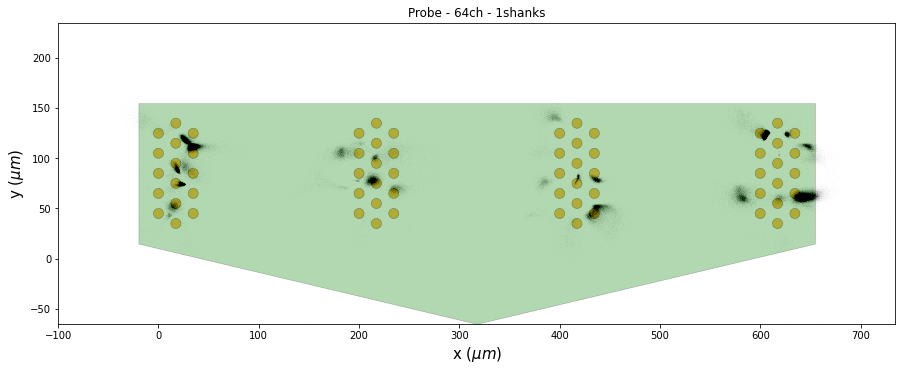

In [13]:
probe = rec_preprocessed.get_probe()
fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.002)
ax.set_xlim(probe_bounds_x)
ax.set_ylim(probe_bounds_y)

In [14]:
### Parameters
refractory_period_ms = 1.0 # number of milliseconds surrounding spike to not allow neighborhood
time_window_s = 60*5 # window for sampling nearest neighbors
margin_ms = 100 # margin for chunking
spike_pre_ms = 1 # time prior to peak
spike_post_ms = 1 # time after peak
n_channel_neighbors = 8 # number of neighbors per channel 
n_neighbors = 5 # number of neighbors for graph construction
knn_verbose = True # whether to make knn computation verbose
low_memory = False # memory usage
n_jobs = -1 # number of jobs to perform computations over

In [15]:
nn_idx = np.load(peak_folder / 'nearest_neighbor_index.npy')
nn_dist = np.load(peak_folder / 'nearest_neighbor_distances.npy')

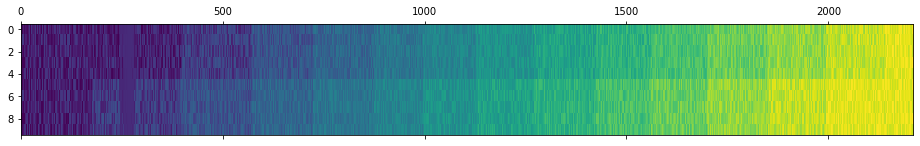

In [16]:
plt.matshow(nn_idx[::100].T, aspect='auto');

### Test embed on full matrix

In [17]:
from tqdm.auto import tqdm

In [18]:
# HACK: since we only have 5 neighbors for some elements in the matrix, 
#   we are sampling only 5 neighbors from *each* element
n_neighbors=5
neighbor_index = np.zeros((len(nn_idx), n_neighbors))
for ii, nns in enumerate(tqdm(nn_idx)):
    unique_nns = np.unique(nns)
    if len(unique_nns) < n_neighbors:
        print('too few connections')
        breakme
        # randomly sample some connections
        vals = np.concatenate(
            [unique_nns, np.arange(ii + 1, ii + 1 + n_neighbors - len(unique_nns))]
        )
        neighbor_index[ii] = vals
        #if np.any(vals) == i:
        #    breakme
    else:
        neighbor_index[ii] = np.random.choice(unique_nns, n_neighbors, replace=False)

  0%|          | 0/221083 [00:00<?, ?it/s]

In [19]:
# get values of matrix as rows and columns to input to scipy sparse matrix function
rows = neighbor_index.flatten()
cols = np.repeat(np.arange(len(neighbor_index)), n_neighbors)
rows_ = np.concatenate([rows, cols])
cols_ = np.concatenate([cols, rows])
rows.shape, cols.shape

((1105415,), (1105415,))

In [20]:
from scipy.sparse import coo_matrix

In [21]:
# create coo matrix
nearest_neighbors_graph = coo_matrix(
    (np.ones(len(rows_)), (rows_, cols_)), shape=(len(neighbor_index), len(neighbor_index))
)
# create csr
nearest_neighbors_graph_csr = nearest_neighbors_graph.tocsr()

In [22]:
from umap import UMAP

In [23]:
embedder_from_nearest_neighbor = UMAP(
    metric="precomputed", verbose=True, n_neighbors=n_neighbors
)

In [24]:
#z_umap_from_nn = embedder_from_nearest_neighbor.fit_transform(nearest_neighbors_graph_csr)
#plt.scatter(z_umap_from_nn[:,0], z_umap_from_nn[:,1], s=1, color='k', alpha = 0.1)

In [25]:
print(nearest_neighbors_graph_csr[0])

  (0, 10459)	2.0
  (0, 12673)	1.0
  (0, 17232)	1.0
  (0, 18642)	1.0
  (0, 38057)	1.0


In [134]:
np.where(nearest_neighbors_graph_csr[-1000].todense())

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([199989, 201252, 201526, 202616, 203050, 206195, 213729, 214308,
        215216, 217934, 219822]))

In [27]:
np.where(nearest_neighbors_graph_csr[-1].todense())

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
 array([202074, 204492, 204569, 204694, 204974, 205651, 206080, 208351,
        211328, 211448, 213072, 213171, 213414, 213993, 215430, 215619,
        216160, 216816, 217348, 217701, 218140, 218702, 218759, 219993]))

In [28]:
nearest_neighbors_graph_csr

<221083x221083 sparse matrix of type '<class 'numpy.float64'>'
	with 1998916 stored elements in Compressed Sparse Row format>

### MDE

In [72]:
import pymde

In [73]:
graph = pymde.Graph(nearest_neighbors_graph_csr)

In [74]:
import torch

In [75]:
knn_graph = graph

In [76]:
n_items = nearest_neighbors_graph.shape[0]

In [144]:
similar_edges = knn_graph.edges
dissimilar_edges = pymde.preprocess.dissimilar_edges(
    n_items=n_items, num_edges=similar_edges.shape[0], similar_edges=similar_edges)

edges = torch.cat([similar_edges, dissimilar_edges])
weights = torch.cat([knn_graph.weights, -1.*torch.ones(dissimilar_edges.shape[0])])

In [145]:
f = pymde.penalties.PushAndPull(
    weights=weights,
    attractive_penalty=pymde.penalties.Log1p,
    repulsive_penalty=pymde.penalties.Log,
)

In [146]:
quadratic_mde = pymde.MDE(
    n_items=n_items,
    embedding_dim=2,
    edges=knn_graph.edges,
    distortion_function=pymde.penalties.Quadratic(knn_graph.weights),
    constraint=pymde.Standardized(),
    device='cuda'
)

Mar 13 03:15:31 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:15:31 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function


In [147]:
#X_init = pymde.quadratic.spectral(
#    n_items, 2, edges, weights, device='cuda'
#)
#mde._X_init = X_init

In [148]:
x =quadratic_mde.embed(verbose=True).cpu()

Mar 13 03:15:31 PM: Fitting a centered embedding into R^2, for a graph with 221083 items and 999458 edges.
Mar 13 03:15:31 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Mar 13 03:15:31 PM: iteration 000 | distortion 4.422853 | residual norm 0.0165676 | step length 3182.51 | percent change 7.92408
Mar 13 03:15:31 PM: iteration 030 | distortion 0.000064 | residual norm 2.75365e-05 | step length 1 | percent change 5.86038
Mar 13 03:15:31 PM: Converged in 043 iterations, with residual norm 9.92822e-06
Mar 13 03:15:31 PM: Finished fitting in 0.153 seconds and 43 iterations.
Mar 13 03:15:31 PM: average distortion 1.54e-05 | residual norm 9.9e-06


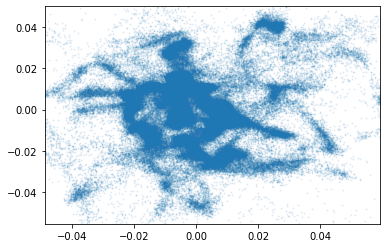

In [149]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots()
ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [150]:
std_mde = pymde.MDE(
    n_items=n_items,
    embedding_dim=2,
    edges=edges,
    distortion_function=f,
    #constraint=pymde.Standardized(),
    device='cuda'
)

x = std_mde.embed(X=quadratic_mde.X, max_iter=400, verbose=True)

Mar 13 03:15:34 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:15:34 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:15:34 PM: Fitting a centered embedding into R^2, for a graph with 221083 items and 1998874 edges.
Mar 13 03:15:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=400, memory_size=10
Mar 13 03:15:34 PM: iteration 000 | distortion 1.960042 | residual norm 0.207164 | step length 0.0154867 | percent change 0.0287954
Mar 13 03:15:34 PM: iteration 040 | distortion 0.107153 | residual norm 0.000357143 | step length 1 | percent change 2.47178
Mar 13 03:15:34 PM: iteration 080 | distortion 0.073580 | residual norm 0.000215257 | step length 1 | percent change 0.265313
Mar 13 03:15:35 PM: iteration 120 | distortion 0.065474 | residual norm 0.000119394 | step length 1 | percent change 0.435711
Mar 13 03:15:35 PM: iteration 160 | distortion 0.0

In [151]:
x = np.array(x.cpu())

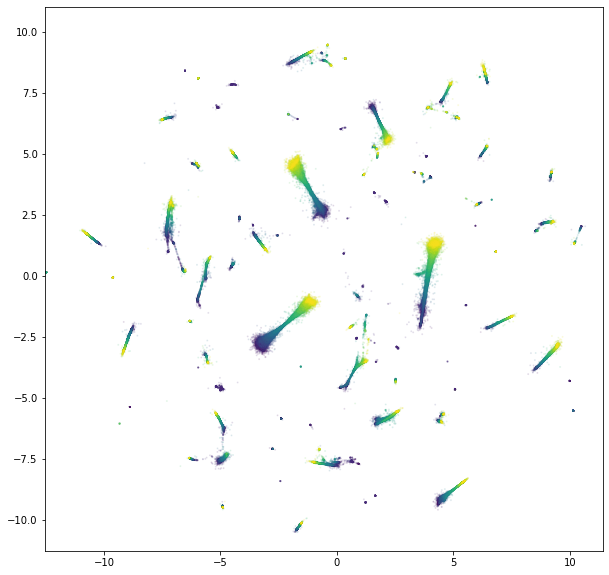

In [152]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1, c = np.arange(len(x)))
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [153]:
negative_to_positive_samples = 5

In [154]:
similar_edges = knn_graph.edges
n_dis = int(len(similar_edges)*negative_to_positive_samples)
dissimilar_edges = pymde.preprocess.dissimilar_edges(
    n_items=n_items, num_edges=n_dis, similar_edges=similar_edges)

edges = torch.cat([similar_edges, dissimilar_edges])
weights = torch.cat([knn_graph.weights, -1.*torch.ones(dissimilar_edges.shape[0])])

In [155]:
f = pymde.penalties.PushAndPull(
    weights=weights,
    attractive_penalty=pymde.penalties.Log1p,
    repulsive_penalty=pymde.penalties.Log,
)

In [156]:
std_mde = pymde.MDE(
    n_items=n_items,
    embedding_dim=2,
    edges=edges,
    distortion_function=f,
    #constraint=pymde.Standardized(),
    device='cuda'
)

x = std_mde.embed(X=quadratic_mde.X, max_iter=400, verbose=True)

Mar 13 03:15:49 PM: edges.device (cpu) does not match requested device (cuda); copying edges to requested device.
Mar 13 03:15:49 PM: distortion_function device (cpu) does not match requested device (cuda); making a copy of distortion_function
Mar 13 03:15:50 PM: Fitting a centered embedding into R^2, for a graph with 221083 items and 5996555 edges.
Mar 13 03:15:50 PM: `embed` method parameters: eps=1.0e-05, max_iter=400, memory_size=10
Mar 13 03:15:50 PM: iteration 000 | distortion 3.266599 | residual norm 0.189683 | step length 0.0121518 | percent change 0.0206881
Mar 13 03:15:50 PM: iteration 040 | distortion 0.096271 | residual norm 0.000152783 | step length 1 | percent change 1.81208
Mar 13 03:15:51 PM: iteration 080 | distortion 0.064967 | residual norm 9.44235e-05 | step length 1 | percent change 0.573256
Mar 13 03:15:52 PM: iteration 120 | distortion 0.055385 | residual norm 6.63787e-05 | step length 1 | percent change 0.36483
Mar 13 03:15:53 PM: iteration 160 | distortion 0.05

In [157]:
x = np.array(x.cpu())

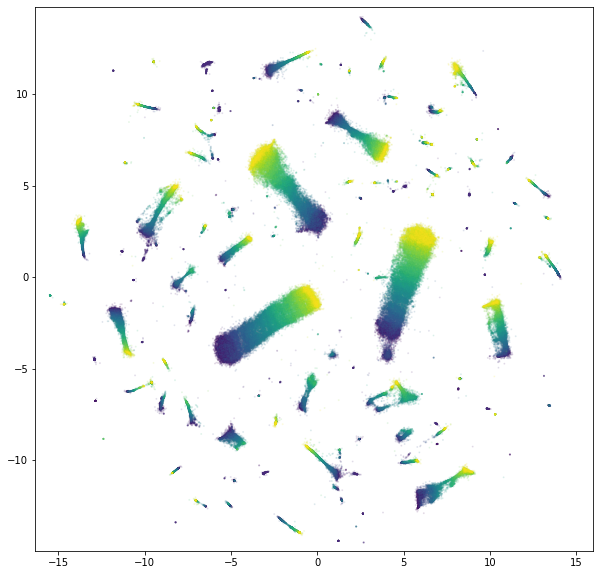

In [158]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1, c = np.arange(len(x)))
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [159]:
import hdbscan
import seaborn as sns

In [160]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000)

In [161]:
clusterer.fit(x)

HDBSCAN(min_cluster_size=1000)

In [162]:
N = len(np.unique(clusterer.labels_))
print(N)

35


In [163]:
from distinctipy import distinctipy

In [164]:
colors = distinctipy.get_colors(N)
colors[0] = (0.9,0.9,0.9)

In [165]:
color_dict = dict(zip(np.unique(clusterer.labels_), colors))

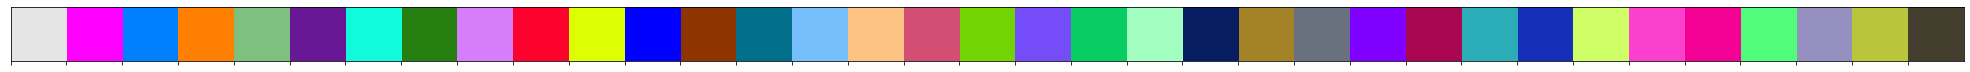

In [166]:
sns.palplot(colors)

In [167]:
c = [color_dict[i] for i in clusterer.labels_]

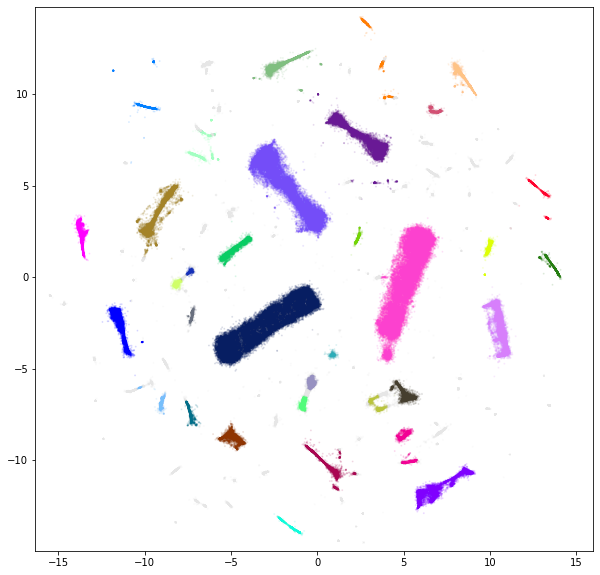

In [168]:
xmin, xmax = np.percentile(x[:,0], (1,99))
ymin, ymax = np.percentile(x[:,1], (1,99))
padding = 0.1
xpad = (xmax - xmin)* padding
ypad = (ymax - ymin)* padding
xmin -=xpad
xmax +=xpad
ymin-=ypad
ymax+=xpad

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x[:,0], x[:,1], s=1, alpha = 0.1, c = c)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

### Plot over locations

In [169]:
preprocess_folder = base_folder / 'spikeinterface-preprocess'

In [170]:
# load back
rec = si.load_extractor(preprocess_folder)

(-150.0, 200.0)

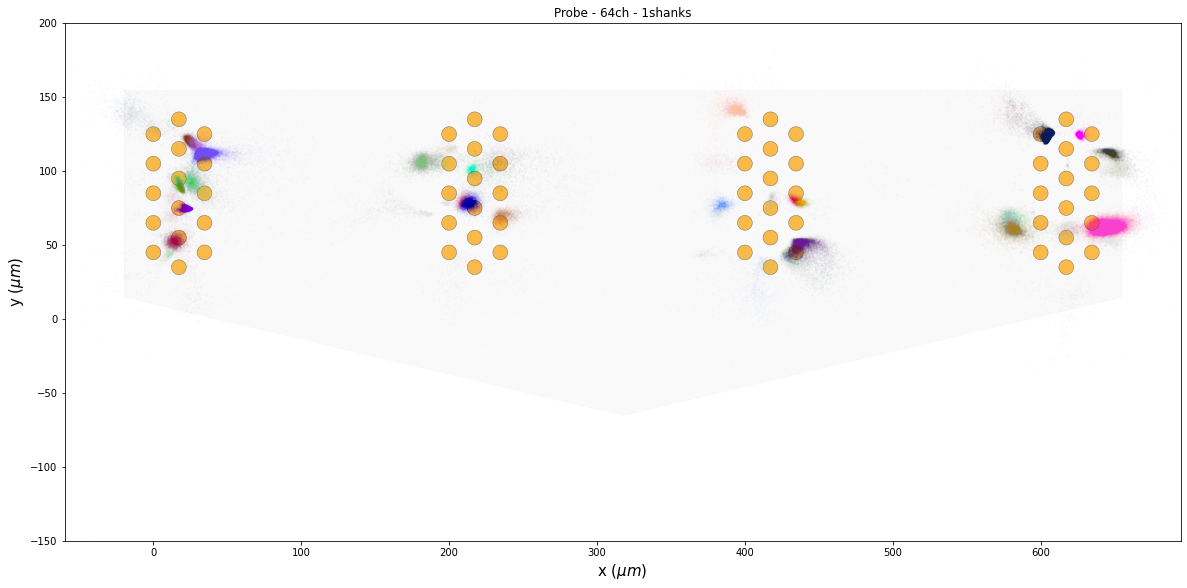

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_probe(rec.get_probe(), ax=ax, probe_shape_kwargs={
    'facecolor': (0,0,0,0.01),
    'alpha':0.025
})
ax.scatter(peak_locations["x"], peak_locations["y"], c=c, s=1, alpha=0.01)
ax.set_ylim(-150, 200)